# Analysing the data

## Important information before proceeding
The units here for all pollutants is $\mu g/m^{3}$. The IMD score is unitless.
#### First, importing the data from SQL joined together with the relevant columns

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os


In [2]:
load_dotenv()
password = os.getenv("DATABASE_PASSWORD")
db_name = os.getenv("DATABASE_NAME")
port = os.getenv("DATABASE_PORT")
hostname = os.getenv("DATABASE_HOSTNAME")
username = os.getenv("DATABASE_USERNAME")

engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}:{port}/{db_name}")

The full query I am doing here is:<br>
select p.geo_code, p.geo_label, p.pm25_2007, p.pm25_2024, p.pm10_2007, p.pm10_2024, p.no2_2007, p.no2_2024, sub.imd07_score, sub.imd19_score, sub.msoarank as msoarank19 <br>
from pollution_msoa p left join <br>
(select i7.msoa11_code, i7.score as imd07_score, i9.imd19_score, i9.msoarank from imd2007 i7 <br> 
left join imd2019 i9 on i7.msoa11_code = i9.msoac) sub on p.geo_code = sub.msoa11_code;

In [3]:
query = "select p.geo_code, p.geo_label, p.pm25_2007, p.pm25_2024, p.pm10_2007, p.pm10_2024, p.no2_2007, p.no2_2024, sub.imd07_score, sub.imd19_score, sub.msoarank as msoarank19 from pollution_msoa p left join (select i7.msoa11_code, i7.score as imd07_score, i9.imd19_score, i9.msoarank from imd2007 i7 left join imd2019 i9 on i7.msoa11_code = i9.msoac) sub on p.geo_code = sub.msoa11_code;"

df = pd.read_sql(query, con=engine)

df.head()

,geo_code,geo_label,pm25_2007,pm25_2024,pm10_2007,pm10_2024,no2_2007,no2_2024,imd07_score,imd19_score,msoarank19
0,E02002873,Nottingham 006,10.720420,7.702422,18.64338,11.95465,22.05027,13.084070,48.025117,37.601338,866.0
1,E02000793,Richmond upon Thames 010,13.415840,8.492700,23.05174,13.04231,31.02554,16.298560,11.179251,11.206442,5179.0
2,E02002661,Kingston upon Hull 010,9.300502,7.248457,16.61529,11.91518,17.33395,9.187561,39.290738,39.315680,760.0
3,E02000077,Bexley 013,12.638760,8.657308,22.06381,13.38199,28.51846,14.747010,13.831107,12.745682,4756.0
4,E02000818,Southwark 012,15.081210,9.819899,27.67150,16.87792,47.45792,24.163360,40.875765,34.455332,1086.0


Creating columns of the differences in pollutants and IMD score

In [5]:
df["delta_pm25"] = df["pm25_2024"] - df["pm25_2007"]
df["delta_pm10"] = df["pm10_2024"] - df["pm10_2007"]
df["delta_no2"] = df["no2_2024"] - df["no2_2007"]
df["delta_imd"] = df["imd19_score"] - df["imd07_score"]

In [6]:
df = df[df.notnull()]

df.head()

,geo_code,geo_label,pm25_2007,pm25_2024,pm10_2007,pm10_2024,no2_2007,no2_2024,imd07_score,imd19_score,msoarank19,delta_pm25,delta_pm10,delta_no2,delta_imd
0,E02002873,Nottingham 006,10.720420,7.702422,18.64338,11.95465,22.05027,13.084070,48.025117,37.601338,866.0,-3.017998,-6.68873,-8.966200,-10.423780
1,E02000793,Richmond upon Thames 010,13.415840,8.492700,23.05174,13.04231,31.02554,16.298560,11.179251,11.206442,5179.0,-4.923140,-10.00943,-14.726980,0.027191
2,E02002661,Kingston upon Hull 010,9.300502,7.248457,16.61529,11.91518,17.33395,9.187561,39.290738,39.315680,760.0,-2.052045,-4.70011,-8.146389,0.024941
3,E02000077,Bexley 013,12.638760,8.657308,22.06381,13.38199,28.51846,14.747010,13.831107,12.745682,4756.0,-3.981452,-8.68182,-13.771450,-1.085426
4,E02000818,Southwark 012,15.081210,9.819899,27.67150,16.87792,47.45792,24.163360,40.875765,34.455332,1086.0,-5.261311,-10.79358,-23.294560,-6.420432


## Generating some plots now to guide the analysis process

The following shows that the worse the air quality in 2007, the more progress was made from 2007 to 2024.

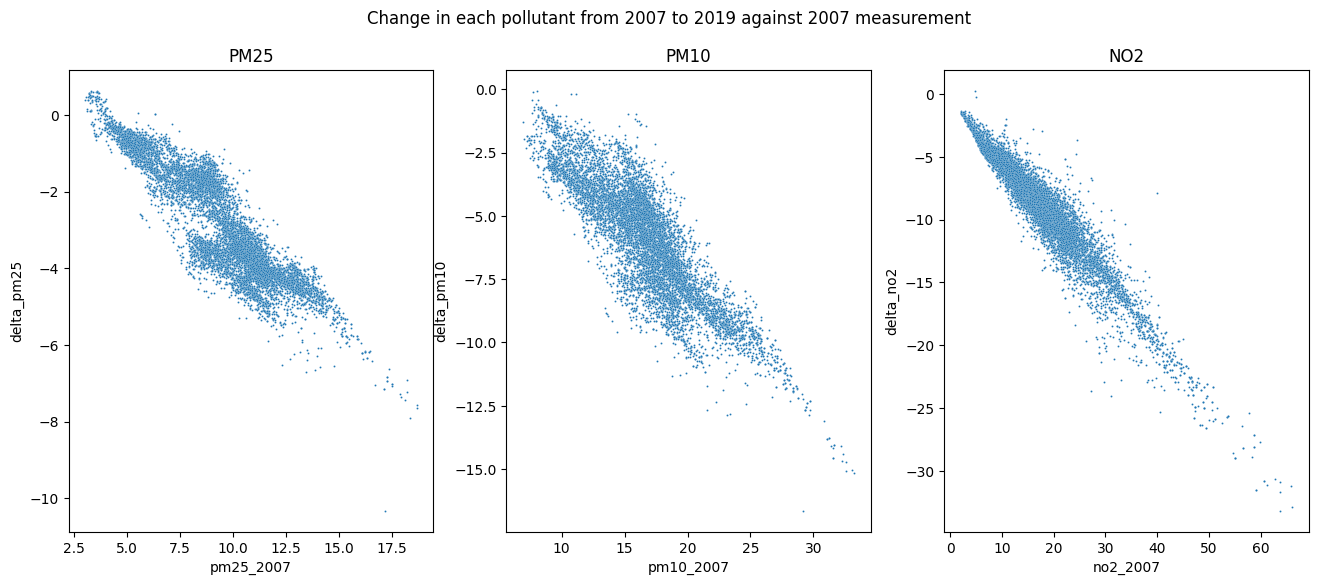

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

x1 = "pm25_2007"
x2 = "pm10_2007"
x3 = "no2_2007"
y1 = "delta_pm25"
y2 = "delta_pm10"
y3 = "delta_no2"

fig, axs = plt.subplots(1, 3, figsize=(16,6))
fig.suptitle("Change in each pollutant from 2007 to 2019 against 2007 measurement")

axs[0].set_title("PM25")
axs[1].set_title("PM10")
axs[2].set_title("NO2")

sns.scatterplot(data=df, ax=axs[0], x=x1, y=y1, s=2)
sns.scatterplot(data=df, ax=axs[1], x=x2, y=y2, s=2)
sns.scatterplot(data=df, ax=axs[2], x=x3, y=y3, s=2)

plt.show()

As can be seen below, there is no immediately obvious correlation between IMD 2007 score and measured air pollution in 2007 for PM25

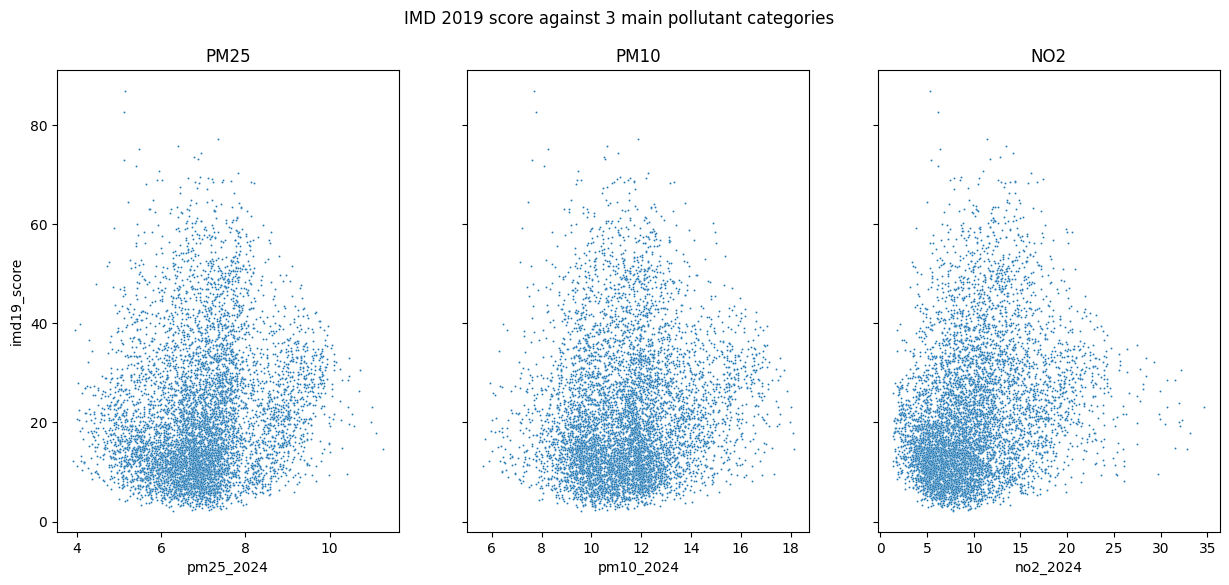

In [10]:
x1 = "pm25_2024"
x2 = "pm10_2024"
x3 = "no2_2024"
y = "imd19_score"

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,6))
fig.suptitle("IMD 2019 score against 3 main pollutant categories")

axs[0].set_title("PM25")
axs[1].set_title("PM10")
axs[2].set_title("NO2")

sns.scatterplot(data=df, ax=axs[0], x=x1, y=y, s=2)
sns.scatterplot(data=df, ax=axs[1], x=x2, y=y, s=2)
sns.scatterplot(data=df, ax=axs[2], x=x3, y=y, s=2)

plt.show()

Below demonstrates that the changes that occured do not appear strongly correlated with IMD 2007 score

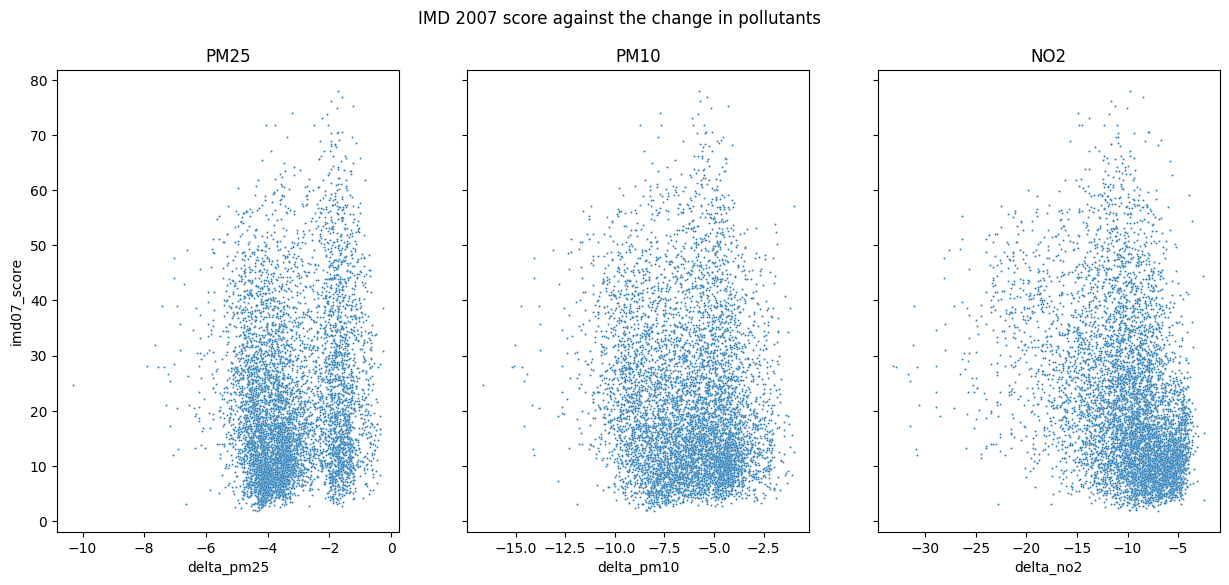

In [14]:
x1 = "delta_pm25"
x2 = "delta_pm10"
x3 = "delta_no2"
y = "imd07_score"

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,6))
fig.suptitle("IMD 2007 score against the change in pollutants")

axs[0].set_title("PM25")
axs[1].set_title("PM10")
axs[2].set_title("NO2")

sns.scatterplot(data=df, ax=axs[0], x=x1, y=y, s=2)
sns.scatterplot(data=df, ax=axs[1], x=x2, y=y, s=2)
sns.scatterplot(data=df, ax=axs[2], x=x3, y=y, s=2)

plt.show()

As can be seen in the above graphs, there is considerable noise confounding the imd scores and the changes in measured pollution. A clear correlation exists between how bad the pollution was before, and how much it has improved since. We want to determine how much importance deprivation has on the improvements independant of how bad the starting air quality was, so to learn this we will do Multiple Linear Regression with dependent variable of the 2024 measured data, the independents being IMD score and measured pollutant data in 2007:

The specific form for the regression here is 
$$P_{2024} = \beta_{0} + \beta_{1} P_{2007} + \beta_{2} IMD_{2007} + \varepsilon$$
Where $P_{yyyy}$ is the pollutant concentration in year $yyyy$, $IMD_{yyyy}$ is the Index of Multiple Deprivation Score in year $yyyy$, $\beta_{n}$ is the nth fit coefficient, and $\epsilon$ is the noise (that is not involved in the regression process, but is the remaining parameters not included that explains the remaining $R^{2}$).

First, it is sensible to check that the independent variables are exactly that, independent. Using statsmodels VIF implementation:

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

df_clean = df[["pm25_2007", "imd07_score"]].dropna()
cl = sm.add_constant(df_clean)  # add intercept term
vif_df = pd.DataFrame()
vif_df['variable'] = cl.columns
vif_df['VIF'] = [variance_inflation_factor(cl.values, i) for i in range(cl.shape[1])]

print(vif_df)


      variable        VIF
0        const  27.891564
1    pm25_2007   1.004696
2  imd07_score   1.004696


In [40]:
df_clean = df[["pm10_2007", "imd07_score"]].dropna()
cl = sm.add_constant(df_clean)  # add intercept term
vif_df = pd.DataFrame()
vif_df['variable'] = cl.columns
vif_df['VIF'] = [variance_inflation_factor(cl.values, i) for i in range(cl.shape[1])]

print(vif_df)

      variable        VIF
0        const  28.318276
1    pm10_2007   1.038538
2  imd07_score   1.038538


In [41]:
df_clean = df[["no2_2007", "imd07_score"]].dropna()
cl = sm.add_constant(df_clean)  # add intercept term
vif_df = pd.DataFrame()
vif_df['variable'] = cl.columns
vif_df['VIF'] = [variance_inflation_factor(cl.values, i) for i in range(cl.shape[1])]

print(vif_df)

      variable       VIF
0        const  6.725509
1     no2_2007  1.201414
2  imd07_score  1.201414


This shows that the VIF between the 2007 pollutant data and the 2007 IMD score is statistically independent enough for the above regression to be trusted. All VIFs round to 1.

Now using statsmodels multilinear regression to find the coefficients and goodness of fits. To avoid 0 extrapolation giving potentially unphysical intercepts, I am going to mean-centre the imd and pollutant data.

In order of PM2.5, PM10, NO2

In [49]:
dfc = df.copy()
dfc['pm25_2007_c'] = dfc['pm25_2007'] - dfc['pm25_2007'].mean()
dfc['imd07_score_c'] = dfc['imd07_score'] - dfc['imd07_score'].mean()

df_clean = dfc[['pm25_2007_c', 'imd07_score_c', 'pm25_2024']].dropna()

X = sm.add_constant(df_clean[['pm25_2007_c', 'imd07_score_c']])
y = df_clean['pm25_2024']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              pm25_2024   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     9927.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:01:40   Log-Likelihood:                -5846.6
No. Observations:                6781   AIC:                         1.170e+04
Df Residuals:                    6778   BIC:                         1.172e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.5961      0.008    877.975

In [50]:
dfc = df.copy()
dfc['pm10_2007_c'] = dfc['pm10_2007'] - dfc['pm10_2007'].mean()
dfc['imd07_score_c'] = dfc['imd07_score'] - dfc['imd07_score'].mean()

df_clean = dfc[['pm10_2007_c', 'imd07_score_c', 'pm10_2024']].dropna()

X = sm.add_constant(df_clean[['pm10_2007_c', 'imd07_score_c']])
y = df_clean['pm10_2024']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              pm10_2024   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     6638.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:01:43   Log-Likelihood:                -10322.
No. Observations:                6781   AIC:                         2.065e+04
Df Residuals:                    6778   BIC:                         2.067e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.9398      0.014    772.028

In [51]:
dfc = df.copy()
dfc['no2_2007_c'] = dfc['no2_2007'] - dfc['no2_2007'].mean()
dfc['imd07_score_c'] = dfc['imd07_score'] - dfc['imd07_score'].mean()

df_clean = dfc[['no2_2007_c', 'imd07_score_c', 'no2_2024']].dropna()

X = sm.add_constant(df_clean[['no2_2007_c', 'imd07_score_c']])
y = df_clean['no2_2024']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               no2_2024   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 4.827e+04
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:04:16   Log-Likelihood:                -10997.
No. Observations:                6782   AIC:                         2.200e+04
Df Residuals:                    6779   BIC:                         2.202e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.0641      0.015    597.623

## Conclusion

The relationships between pollutant concentrations and deprivation as detailed by the Index of Multiple Deprivation (IMD) are, as modelled by multilinear regression, the following:

### For Particulate matter with diameter less than 2.5 microns:

$$PM_{2.5,2024} = 6.5961 + 0.4621(PM_{2.5,2007} - \overline{PM_{2.5,2007}}) + 0.0170(IMD_{2007} - \overline{IMD_{2007}})$$

The variables $PM_{2.5,2007}$ and $IMD_{2007}$ have VIF $1.0047$ so can be treated as independent. The $R^{2} = 0.745$, and all three fit coefficients have P-values of less than $0.001$.

### For Particulate matter with diameter less than 10 microns:

$$PM_{10,2024} = 10.9398 + 0.4453(PM_{10,2007} - \overline{PM_{10,2007}}) + 0.0089(IMD_{2007} - \overline{IMD_{2007}})$$

The variables $PM_{10,2007}$ and $IMD_{2007}$ have VIF $1.0385$ so can be treated as independent. The $R^{2} = 0.662$, and all three fit coefficients have P-values of less than $0.001$.

### For Nitrogen Dioxide:

$$NO2_{2024} = 9.0641 + 0.5250(NO2_{2007} - \overline{NO2_{2007}}) + 0.0086(IMD_{2007} - \overline{IMD_{2007}})$$

The variables $NO2_{2007}$ and $IMD_{2007}$ have VIF $1.2014$ so can be treated as independent. The $R^{2} = 0.934$, and all three fit coefficients have P-values of less than $0.001$.

In all three situations, there is a slightly positive relationship between the 2024 pollutant data and the 2007 IMD data, suggesting that more deprived areas (higher IMD score) do in fact suffer slightly worse air quality in 2024 compared to more developed areas that had the same pollution in 2007. This correlation is only slight. For $PM_{2.5}$ and $PM_{10}$ the $R^{2}$ shows that there is still significant variation that is not explained by the currently given parameters. Some potential future avenues for filling these gaps include the geography (urban vs more rural large towns vs rural) and potentially meteorological factors.